# NOTE:
Most of the scripts in below notebooks are not proper way, and it intentionaly the way they are as not having enough access to powerful GPUs, or free quora on Colab

# Multimodal ML – Housing Price Prediction Using Images + Tabular Data

Predict housing prices using both structured data and house images.

## The images dataset is in "https://github.com/emanhamed/Houses-dataset"

It contains 4 images for each house and a txt file that contains the metadata.

## Clone the repository

In [1]:
!git clone https://github.com/emanhamed/Houses-dataset.git

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165 (from 1)
Receiving objects: 100% (2166/2166), 176.26 MiB | 42.55 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [2]:
import os
os.listdir("Houses-dataset")

['Houses Dataset', '.git', '.gitignore', 'README.md', '.gitattributes']

### Searching in the folder to find the file name for the metadata

In [3]:
!ls '/content/Houses-dataset/Houses Dataset' | grep -v "\.jpg$"

HousesInfo.txt


In [4]:
!head '/content/Houses-dataset/Houses Dataset/HousesInfo.txt'

4 4 4053 85255 869500
4 3 3343 36372 865200
3 4 3923 85266 889000
5 5 4022 85262 910000
3 4 4116 85266 971226
4 5 4581 85266 1249000
3 4 2544 85262 799000
4 5 5524 85266 1698000
3 4 4229 85255 1749000
4 5 3550 85262 1500000


## Convert txt file to csv
The text file doesn't have ids of images, so adding auto increment numbers to each line in csv

In [5]:
!awk 'BEGIN{OFS=","; print "id,bedrooms,bathrooms,area,zipcode,price"} {print NR,$1,$2,$3,$4,$5}' '/content/Houses-dataset/Houses Dataset/HousesInfo.txt' > '/content/Houses-dataset/Houses Dataset/HousesInfo.csv'

import with pandas

In [6]:
import pandas as pd

df = pd.read_csv("/content/Houses-dataset/Houses Dataset/HousesInfo.csv")

In [7]:
# converting all columns to integers to avoid later issues
df['id'] = df['id'].astype(int)
df['bedrooms'] = df['bedrooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)
df['area'] = df['area'].astype(int)
df['zipcode'] = df['zipcode'].astype(int)
df['price'] = df['price'].astype(int)

In [8]:
df.head()

,id,bedrooms,bathrooms,area,zipcode,price
0,1,4,4,4053,85255,869500
1,2,4,3,3343,36372,865200
2,3,3,4,3923,85266,889000
3,4,5,5,4022,85262,910000
4,5,3,4,4116,85266,971226


In [9]:
df.count()

,0
id,535
bedrooms,535
bathrooms,535
area,535
zipcode,535
price,535


## features and labels from text data

In [10]:
X = df.drop('price', axis=1)
y = df['price']

In [11]:
X, y

(      id  bedrooms  bathrooms  area  zipcode
 0      1         4          4  4053    85255
 1      2         4          3  3343    36372
 2      3         3          4  3923    85266
 3      4         5          5  4022    85262
 4      5         3          4  4116    85266
 ..   ...       ...        ...   ...      ...
 530  531         5          2  2066    94531
 531  532         4          3  9536    94531
 532  533         3          2  2014    94531
 533  534         4          3  2312    94531
 534  535         5          3  3796    94531
 
 [535 rows x 5 columns],
 0      869500
 1      865200
 2      889000
 3      910000
 4      971226
         ...  
 530    399900
 531    460000
 532    407000
 533    419000
 534    615000
 Name: price, Length: 535, dtype: int64)

## Preprocessing images to resize, grayscale and normalize for the pretrained CNN

In [12]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Create a custom dataset from the images on folder
The custom dataest must be inherit from `Dataset` so pytorch understands it, and also the `__len__`, `__getitem__` must be implemented.

In [13]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import os

class HouseDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        house_id = row['id']

        img_types = ['bathroom', 'bedroom', 'kitchen', 'frontal']
        images = []
        for t in img_types:
            img_path = os.path.join(self.image_dir, f"{house_id}_{t}.jpg")
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            images.append(img)

        images = torch.stack(images)

        # Tabular features
        tabular_features = torch.tensor([
            row['bedrooms'],
            row['bathrooms'],
            row['area']
        ], dtype=torch.float32)

        # Label
        label = torch.tensor(row['price'], dtype=torch.float32)

        return images, tabular_features, label


### Checking the above dataset if works properly, also plotting the house with labels

- first unnormalize it
- plot it with labels for the house info and price

In [14]:
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_tensor = img_tensor * std + mean
    img_tensor = img_tensor.clamp(0,1)
    return img_tensor

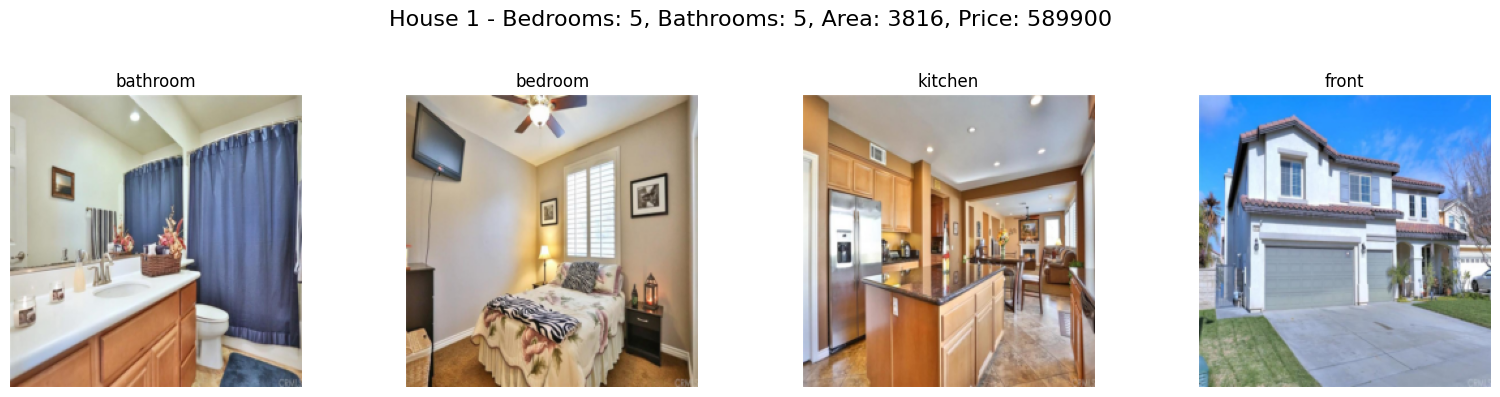

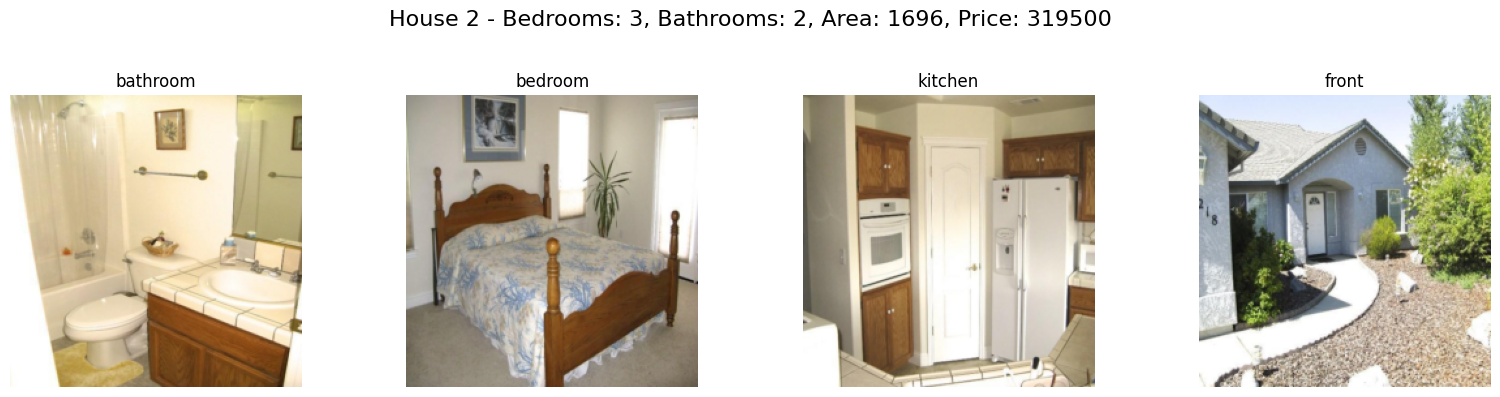

In [15]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = HouseDataset(df=df,
                       image_dir='/content/Houses-dataset/Houses Dataset/',
                       transform=transform)

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Take one batch
images, tabular, price = next(iter(dataloader))

# Plot first 2 houses
for i in range(min(2, images.size(0))):
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    img_types = ['bathroom', 'bedroom', 'kitchen', 'front']

    # Set one overall title for the house
    fig.suptitle(f"House {i+1} - Bedrooms: {int(tabular[i,0].item())}, "
                 f"Bathrooms: {int(tabular[i,1].item())}, "
                 f"Area: {tabular[i,2].item():.0f}, "
                 f"Price: {price[i].item():.0f}", fontsize=16)

    for j in range(4):
        # plots images the way they are on dataset
        # img = images[i, j]
        # img = img.permute(1, 2, 0)

        # unnormalize images and then plots them
        img = unnormalize(images[i,j])          # [3,224,224]
        img = img.permute(1,2,0).numpy()        # HWC
        axes[j].imshow(img)
        axes[j].axis('off')
        axes[j].set_title(img_types[j], fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # leave space for suptitle
    plt.show()


## We use RESNET CNN Model

Resnet is already a free trained model, we can fine-tune for our case.


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models

class HousePriceModel(nn.Module):
    def __init__(self, tabular_dim=3):
        super().__init__()

        # ---- CNN backbone (shared for all 4 images) ----
        base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.cnn = nn.Sequential(*list(base_model.children())[:-1])
        cnn_out_dim = 512

        # ---- Tabular branch ----
        self.tabular_net = nn.Sequential(
            nn.Linear(tabular_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )

        # ---- Fusion head ----
        self.regressor = nn.Sequential(
            nn.Linear(cnn_out_dim + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, images, tabular):
        """
        images: (B, 4, 3, H, W)
        tabular: (B, 3)
        """

        B, N, C, H, W = images.shape
        images = images.view(B * N, C, H, W)

        # CNN feature extraction
        img_features = self.cnn(images)            # (B*N, 512, 1, 1)
        img_features = img_features.view(B, N, -1) # (B, 4, 512)

        # Aggregate 4 views
        img_features = img_features.mean(dim=1)    # (B, 512)

        # Tabular features
        tab_features = self.tabular_net(tabular)    # (B, 32)

        # Fusion
        fused = torch.cat([img_features, tab_features], dim=1)

        # Regression
        price = self.regressor(fused).squeeze(1)

        return price


Due to limited GPUs quota issue, those hyperparameters are not tuned

In [30]:
# Hyperparameters
EPOCHS = 30
LR = 1e-4

The train function with adam optimizer.

In [18]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

def train(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_mae": [],
        "val_mae": [],
        "train_rmse": [],
        "val_rmse": []
    }

    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        train_preds, train_targets = [], []

        for images, tabular, y in train_loader:
            images, tabular, y = images.to(device), tabular.to(device), y.to(device)

            optimizer.zero_grad()
            preds = model(images, tabular)

            loss = F.mse_loss(preds, y)
            loss.backward()
            optimizer.step()

            train_preds.append(preds.detach().cpu())
            train_targets.append(y.cpu())

        train_preds = torch.cat(train_preds)
        train_targets = torch.cat(train_targets)

        train_mae = torch.mean(torch.abs(train_preds - train_targets))
        train_rmse = torch.sqrt(torch.mean((train_preds - train_targets) ** 2))

        # -------- Validation --------
        model.eval()
        val_preds, val_targets = [], []

        with torch.no_grad():
            for images, tabular, y in val_loader:
                images, tabular, y = images.to(device), tabular.to(device), y.to(device)
                preds = model(images, tabular)

                val_preds.append(preds.cpu())
                val_targets.append(y.cpu())

        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)

        val_mae = torch.mean(torch.abs(val_preds - val_targets))
        val_rmse = torch.sqrt(torch.mean((val_preds - val_targets) ** 2))

        # Save history
        history["train_mae"].append(train_mae.item())
        history["val_mae"].append(val_mae.item())
        history["train_rmse"].append(train_rmse.item())
        history["val_rmse"].append(val_rmse.item())

        print(
            f"Epoch {epoch+1}/{epochs} | "
            f"Train MAE: {train_mae:.2f}, RMSE: {train_rmse:.2f} | "
            f"Val MAE: {val_mae:.2f}, RMSE: {val_rmse:.2f}"
        )

    return history


The matplotlib plot function to plot MAE and RMSE

In [19]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    epochs = range(1, len(history["train_mae"]) + 1)

    # MAE
    plt.figure()
    plt.plot(epochs, history["train_mae"])
    plt.plot(epochs, history["val_mae"])
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.title("MAE over Epochs")
    plt.legend(["Train", "Validation"])
    plt.show()

    # RMSE
    plt.figure()
    plt.plot(epochs, history["train_rmse"])
    plt.plot(epochs, history["val_rmse"])
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("RMSE over Epochs")
    plt.legend(["Train", "Validation"])
    plt.show()


In [20]:
from torch.utils.data import DataLoader
from torchvision import transforms

Images normalization

In [21]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

The dataset created above from images and tabular data are splitted into train and validation below

In [22]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


checking the ration of train and val sets.

In [23]:
len(train_dataset), len(val_dataset)

(428, 107)

setting device to CUDA if avaialable otherwise normal cpu will be used.
and also creates model from HousePriceModel

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = HousePriceModel(tabular_dim=3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]


starts the training

In [31]:
history = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    lr=LR,
    device=device
)

Epoch 1/30 | Train MAE: 599180.50, RMSE: 769166.75 | Val MAE: 550004.31, RMSE: 814383.62
Epoch 2/30 | Train MAE: 599170.44, RMSE: 769150.81 | Val MAE: 549979.12, RMSE: 814363.38
Epoch 3/30 | Train MAE: 599157.62, RMSE: 769133.12 | Val MAE: 549995.81, RMSE: 814374.94
Epoch 4/30 | Train MAE: 599140.62, RMSE: 769104.94 | Val MAE: 549963.94, RMSE: 814349.75
Epoch 5/30 | Train MAE: 599119.19, RMSE: 769080.25 | Val MAE: 549924.75, RMSE: 814319.94
Epoch 6/30 | Train MAE: 599094.06, RMSE: 769041.88 | Val MAE: 549902.19, RMSE: 814300.56
Epoch 7/30 | Train MAE: 599062.81, RMSE: 768997.12 | Val MAE: 549864.56, RMSE: 814271.69
Epoch 8/30 | Train MAE: 599028.62, RMSE: 768937.44 | Val MAE: 549826.50, RMSE: 814235.06
Epoch 9/30 | Train MAE: 598983.38, RMSE: 768879.00 | Val MAE: 549922.75, RMSE: 814311.00
Epoch 10/30 | Train MAE: 598938.62, RMSE: 768813.88 | Val MAE: 550000.69, RMSE: 814375.88
Epoch 11/30 | Train MAE: 598879.69, RMSE: 768712.50 | Val MAE: 549827.75, RMSE: 814219.12
Epoch 12/30 | Train

plots metrics from history

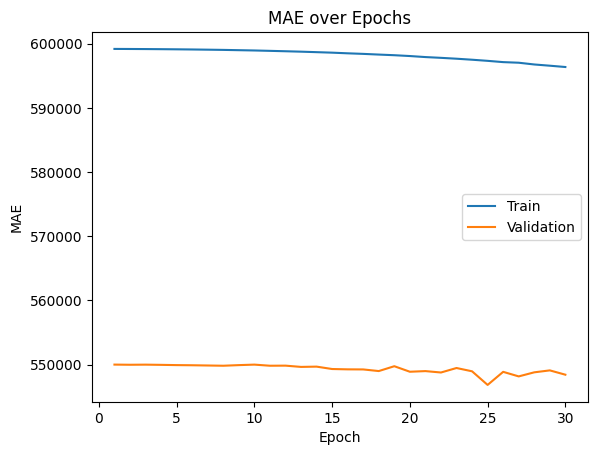

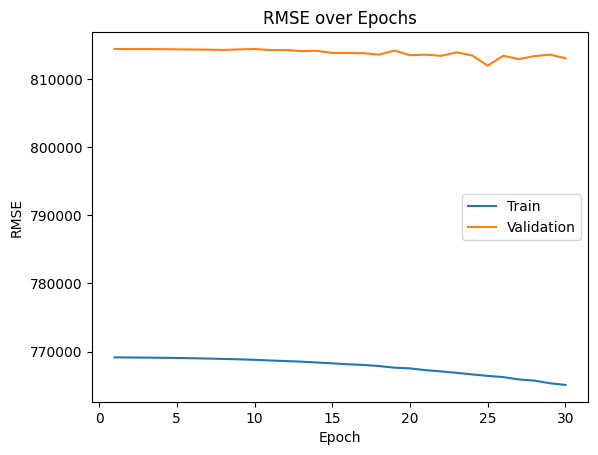

In [32]:
plot_metrics(history)

saving the model state_dict for later use.
the state_dict has the weights of the model.

In [33]:
torch.save(model.state_dict(), "house_price_multimodal.pth")